# Import packages

In [3]:
# !pip install -qU newsapi-python
# !pip install -qU vaderSentiment
# !pip install -qU yfinance
# !pip install -qU alpaca-py

In [4]:
# !pip install black[jupyter]
## run source activate python3
## black Backtesting_Framework.ipynb in terminal

In [1]:
import sys
print(sys.executable)

/Users/yuwensun/Documents/研究生/Multi-Machine-Learning-Strategy-and-Backtesting/.conda/bin/python


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABCMeta, abstractmethod
import requests
from pandas.tseries.offsets import BDay
# from newsapi import NewsApiClient
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# import boto3
# from botocore.exceptions import ClientError
import json

%matplotlib inline

# Dataloader

In [3]:
## Load from Alpaca
class DataLoader:
    def __init__(self, stock_client):
        self.stock_client = stock_client
        
    def fetch_historical_data(self, symbol, start_date=None, end_date=None):
        request_params = StockBarsRequest(
                                symbol_or_symbols=[symbol],
                                timeframe=TimeFrame.Day,
                                start=start_date
                        )
        bars_df = self.stock_client.get_stock_bars(request_params).df

        bars_df = (
            bars_df[['open', 'high', 'low', 'close', 'volume']]
            .reset_index().drop('symbol', axis=1)
        )

        bars = (
            bars_df
            .set_index(keys='timestamp', drop=True)
            .rename(columns={
                'open': 'Open', 
                'high': 'High', 
                'low': 'Low', 
                'close': 'Close', 
                'volume': 'Volume'
                })
        )
        
        # print(bars.index[0].date())
        # print(type(bars.index[0]))
        # bars.index = bars.index.strftime('%Y-%m-%d')
        bars.index = [i.date() for i in bars.index]
        bars.index.name = 'Date'

        return bars
        # return bars_df

In [4]:
# DataLoader(client).fetch_historical_data(symbol, start_date)

# Abstract classes

## Strategy

In [5]:
class Strategy(object):
    """Strategy is an abstract base class providing an interface for
    all subsequent (inherited) trading strategies.

    The goal of a (derived) Strategy object is to output a list of signals,
    which has the form of a time series indexed pandas DataFrame.

    In this instance only a single symbol/instrument is supported."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        """An implementation is required to return the DataFrame of symbols
        containing the signals to go long, short or hold (1, -1 or 0)."""
        raise NotImplementedError("Should implement generate_signals()!")

## Portfolio

In [6]:
class Portfolio(object):
    """An abstract base class representing a portfolio of
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")

# Strategy subclasses

## Random Strategy

In [7]:
class RandomForecastingStrategy(Strategy):
    """Derives from Strategy to produce a set of signals that
    are randomly generated long/shorts. Clearly a nonsensical
    strategy, but perfectly acceptable for demonstrating the
    backtesting infrastructure!"""

    def __init__(self, symbol, bars):
        """Requires the symbol ticker and the pandas DataFrame of bars"""
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        """Creates a pandas DataFrame of random signals."""
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = np.sign(np.random.randn(len(signals)))

        # The first five elements are set to zero in order to minimise
        # upstream NaN errors in the forecaster.
        signals["signal"][0:5] = 0.0
        return signals

## MovingAverageCrossStrategy

In [8]:
class MovingAverageCrossStrategy(Strategy):
    def __init__(self, symbol, bars, short_window=2, long_window=5):
        self.symbol = symbol
        self.bars = bars
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = 0.0

        signals["short_mavg"] = (
            self.bars["Close"].rolling(self.short_window, min_periods=1).mean()
        )
        signals["long_mavg"] = (
            self.bars["Close"].rolling(self.long_window, min_periods=1).mean()
        )

        # print(signals['short_mavg'][self.short_window:].shift(1) < signals['long_mavg'][self.short_window:].shift(1))

        
        signals["signal"][self.short_window :] = np.where(
            (
                (
                    signals["short_mavg"][self.short_window :]
                    > signals["long_mavg"][self.short_window :]
                )
                & (
                    signals["short_mavg"][self.short_window :].shift(1)
                    < signals["long_mavg"][self.short_window :].shift(1)
                )
            ),
            1.0,
            0.0,
        )

        signals["signal"][self.short_window :] = np.where(
            (
                (
                    signals["short_mavg"][self.short_window :]
                    < signals["long_mavg"][self.short_window :]
                )
                & (
                    signals["short_mavg"][self.short_window :].shift(1)
                    > signals["long_mavg"][self.short_window :].shift(1)
                )
            ),
            -1.0,
            signals["signal"][self.short_window:],
        )

        # # signals['positions'] = signals['signal'].diff()
        # signals['positions'] = signals['signal'].cumsum()

        return signals

## Sentiment Analysis Strategy

### TradingDateCalculator

In [9]:
class TradingDateCalculator:
    @staticmethod
    def get_trade_open(date):
        curr_date_open = pd.to_datetime(date).floor("d").replace(
            hour=13, minute=30
        ) - BDay(0)
        curr_date_close = pd.to_datetime(date).floor("d").replace(
            hour=20, minute=0
        ) - BDay(0)

        prev_date_close = (curr_date_open - BDay()).replace(hour=20, minute=0)
        next_date_open = (curr_date_close + BDay()).replace(hour=13, minute=30)

        if (pd.to_datetime(date) >= prev_date_close) & (
            pd.to_datetime(date) < curr_date_open
        ):
            return curr_date_open
        elif (pd.to_datetime(date) >= curr_date_close) & (
            pd.to_datetime(date) < next_date_open
        ):
            return next_date_open
        else:
            return None


class NewsLoader:
    def __init__(self, news_api_key):
        self.news_api_key = news_api_key
        self.url = "https://newsapi.org/v2/everything?"

    def load_news(self, symbol, pageSize=100):  # Timeframe,
        parameters = {
            "q": symbol,
            "sortBy": "popularity",
            "pageSize": pageSize,
            "apiKey": self.news_api_key,
        }

        response = requests.get(self.url, params=parameters)
        data = pd.DataFrame(response.json())

        # Transformation to data for use
        news_df = pd.concat([data["articles"].apply(pd.Series)], axis=1)

        # This is sentiment analysi regarding to headlines
        final_news = news_df[["publishedAt", "title"]].copy(deep=True)
        final_news["publishedAt"] = pd.to_datetime(final_news["publishedAt"])
        final_news = final_news.sort_values(by="publishedAt").reset_index(drop=True)

        # Change according to business day
        final_news.loc[:, "trading_time"] = final_news["publishedAt"].apply(
            TradingDateCalculator.get_trade_open
        )  # def get_trade_open(date):
        final_news = final_news[final_news["trading_time"].notnull()].copy()
        final_news.loc[:, "Date"] = pd.to_datetime(final_news["trading_time"]).dt.date
        final_news = final_news.drop(labels=["publishedAt", "trading_time"], axis=1)

        return final_news

### SentimentAnalysis

In [10]:
class SentimentAnalyzer:
    def __init__(self):
        self.sentiment_analyzer = SentimentIntensityAnalyzer()

    def score_each_article(self, final_news):
        cs = []
        for idx, row in final_news.iterrows():
            cs.append(self.sentiment_analyzer.polarity_scores(row["title"])["compound"])

        final_news.loc[:, "compound_vader_score"] = cs
        article_score = final_news[
            (final_news[["compound_vader_score"]] != 0).all(axis=1)
        ].reset_index(drop=True)

        return article_score

    def daily_compound_sentiment_score(self, final_news):
        """
        Input: DataFrame; |publishedAt|title|
        Output: DataFrame; |Date|Score|
        """
        article_score = self.score_each_article(final_news)

        # Get unique dates
        unique_dates = article_score["Date"].unique()
        grouped_dates = article_score.groupby(["Date"])
        keys_dates = list(grouped_dates.groups.keys())

        # get max/min score daily
        max_cs = []
        min_cs = []

        for key in keys_dates:
            data = grouped_dates.get_group(key)
            if data["compound_vader_score"].max() > 0:
                max_cs.append(data["compound_vader_score"].max())
            elif data["compound_vader_score"].max() < 0:
                max_cs.append(0)

            if data["compound_vader_score"].min() < 0:
                min_cs.append(data["compound_vader_score"].min())
            elif data["compound_vader_score"].min() > 0:
                min_cs.append(0)

        # figure compound socre
        extreme_scores_dict = {
            "Date": keys_dates,
            "max_scores": max_cs,
            "min_scores": min_cs,
        }
        extreme_scores_df = pd.DataFrame(extreme_scores_dict)

        final_scores = []
        for i in range(len(extreme_scores_df)):
            final_scores.append(
                extreme_scores_df["max_scores"][i] + extreme_scores_df["min_scores"][i]
            )

        daily_score = pd.DataFrame({"Date": keys_dates, "Score": final_scores})

        return daily_score

In [11]:
class NewsSentimentAnalysis:
    def __init__(self, news_api_key):
        self.news_loader = NewsLoader(news_api_key)
        self.sentiment_analyzer = SentimentAnalyzer()

    def analyze_sentiment(self, symbol, pageSize=100):
        final_news = self.news_loader.load_news(symbol, pageSize)
        return self.sentiment_analyzer.daily_compound_sentiment_score(final_news)

### SentimentAnalysis Strategy

In [12]:
class SentimentAnalysisStrategy(Strategy):
    def __init__(self, symbol, bars, threshold, news_api_key):
        self.symbol = symbol
        self.bars = bars
        self.threshold = threshold  # 0.2
        self.news_loader = NewsLoader(news_api_key)
        self.sentiment_analyzer = SentimentAnalyzer()

    def generate_news_signals(self):
        score_df = self.sentiment_analyzer.daily_compound_sentiment_score(
            self.news_loader.load_news(self.symbol)
        )

        vader_Buy, vader_Sell = [], []
        for i in range(len(score_df)):
            if score_df["Score"].values[i] > self.threshold:
                # print(f"Trade Call for {extreme_scores_df['Date'][i]} is Buy.")
                vader_Buy.append(score_df["Date"][i])
            elif score_df["Score"].values[i] < -self.threshold:
                # print(f"Trade Call for {extreme_scores_df['Date'][i]} is Sell.")
                vader_Sell.append(score_df["Date"][i])
        return vader_Buy, vader_Sell

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals["signal"] = 0.0

        vader_Buy, vader_Sell = self.generate_news_signals()

        for i in range(len(self.bars)):
            if self.bars.index[i].date() in vader_Buy:
                signals.iloc[i, :] = 1.0

        for i in range(len(self.bars)):
            if self.bars.index[i].date() in vader_Sell:
                signals.iloc[i, :] = -1.0

        return signals

## Logistic Regression Strategy

In [13]:
class LogisticRegressionStrategy(Strategy):
    def __init__(self, threshold, symbol, full_bars, model):
        self.symbol = symbol
        self.bars = full_bars
        self.threshold = threshold
        self.model = model
    
    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        # signals["signal"] = 0.0
        
        ss = MinMaxScaler()
        scaled_bars = ss.fit_transform(self.bars)
        pred_prob = self.model.predict_proba(np.array(scaled_bars))
        signals["signal"] = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > self.threshold else 0, axis=1).tolist()
        
        return signals

In [14]:
# # load the model from disk
# clf_pred = pickle.load(open(filename, 'rb'))

In [15]:
# pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.527 else 0, axis=1).value_counts()

In [16]:
# signals = pd.DataFrame(index=full_data.index)
# # signals["signal"] = 0.0

# ss = MinMaxScaler()
# scaled_bars = ss.fit_transform(full_data)
# pred_prob = clf_pred.predict_proba(np.array(scaled_bars))
# signals["signal"] = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.527 else 0, axis=1).tolist()

# signals

# ML strategies exploration

In [18]:
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical import StockHistoricalDataClient # Create stock historical data client

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [83]:
symbol = 'AMD'
api_key = "PK6IRONYS5AQ646ZTDKX"
api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
client = StockHistoricalDataClient(api_key, api_secret)

start_date = "2014-01-01 00:00:00"

data_loader = DataLoader(client)
bars = data_loader.fetch_historical_data(symbol, start_date=start_date)

In [84]:
bars

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,2.770,2.8200,2.63,2.770,33698464.0
2016-01-05,2.770,2.8000,2.64,2.750,13372522.0
2016-01-06,2.660,2.7100,2.47,2.505,24280750.0
2016-01-07,2.430,2.4800,2.26,2.275,22577907.0
2016-01-08,2.360,2.4250,2.10,2.140,34037306.0
...,...,...,...,...,...
2024-09-25,158.500,162.9500,158.18,162.020,35233264.0
2024-09-26,167.055,168.6800,164.05,167.490,38044919.0
2024-09-27,167.480,168.7286,163.74,164.350,27876037.0


In [49]:
delta = 0.015
bars_cls = bars.copy()
bars_cls['Signal'] = [int(row['High'] >= (1 + delta) * row['Open']) for idx, row in bars_cls.iterrows()]

In [50]:
# bars_cls['Signal'].value_counts()
bars_cls

,Open,High,Low,Close,Volume,Signal
Date,,,,,,
2016-01-04,2.770,2.8200,2.63,2.7700,33698464.0,1
2016-01-05,2.770,2.8000,2.64,2.7500,13372522.0,0
2016-01-06,2.660,2.7100,2.47,2.5050,24280750.0,1
2016-01-07,2.430,2.4800,2.26,2.2750,22577907.0,1
2016-01-08,2.360,2.4250,2.10,2.1400,34037306.0,1
...,...,...,...,...,...,...
2024-09-25,158.500,162.9500,158.18,162.0200,35233264.0,1
2024-09-26,167.055,168.6800,164.05,167.4900,38044919.0,0
2024-09-27,167.480,168.7286,163.74,164.3500,27876037.0,0


#### Logistic Regression

* 1 - Appropriate outcome type (Must be categorical)

* 2 - Linearity of independent variables and log odds

* 3 - No strongly influential outliers

* 4 - Absence of multicollinearity

* 5 - Independence of observations

* 6 - Sufficiently large sample size

In [24]:
period = 50
feature_lst = ['Open', 'High', 'Low', 'Close']
for feature in feature_lst:
    bars_cls[feature] = bars_cls[feature].rolling(period).mean()
    bars_cls.rename(columns={feature: f'{feature}_{period}'}, inplace=True)

bars_cls.dropna(inplace=True)

In [25]:
bars_cls

,Open_50,High_50,Low_50,Close_50,Volume,Signal
Date,,,,,,
2016-03-15,2.1646,2.240600,2.085600,2.157800,21961851.0,0
2016-03-16,2.1592,2.237000,2.082800,2.155000,13397577.0,1
2016-03-17,2.1592,2.237200,2.084000,2.156000,29553221.0,0
2016-03-18,2.1620,2.241600,2.090000,2.164500,29824090.0,1
2016-03-21,2.1714,2.250000,2.099800,2.175000,14153242.0,0
...,...,...,...,...,...,...
2024-09-25,147.0381,149.725046,143.367744,146.194000,35233264.0,1
2024-09-26,146.9832,149.702646,143.461344,146.355200,38044919.0,0
2024-09-27,147.0646,149.809018,143.672144,146.526800,27876037.0,0


##### Assumption 2: Linear independence

In [26]:
bars_cls_linear = bars_cls.copy()
bars_cls_linear['Volume'] = bars_cls_linear['Volume'].apply(lambda x: np.sqrt(x))
for feature in bars_cls_linear.columns[:-1].tolist():
    bars_cls_linear[f'{feature}Log{feature}'] = bars_cls_linear[[feature]].apply(lambda x: x*np.log(x))

Change Volume to sqrt(Volume) will keep linear relationship

In [27]:
bars_cls_linear['Volume'] = (bars_cls_linear['Volume'] - min(bars_cls_linear['Volume'])) / (max(bars_cls_linear['Volume']) - min(bars_cls_linear['Volume']))
bars_cls_linear['VolumeLogVolume'] = (bars_cls_linear['VolumeLogVolume'] - min(bars_cls_linear['VolumeLogVolume'])) / (max(bars_cls_linear['VolumeLogVolume']) - min(bars_cls_linear['VolumeLogVolume']))
bars_cls_linear

,Open_50,High_50,Low_50,Close_50,Volume,Signal,Open_50LogOpen_50,High_50LogHigh_50,Low_50LogLow_50,Close_50LogClose_50,VolumeLogVolume
Date,,,,,,,,,,,
2016-03-15,2.1646,2.240600,2.085600,2.157800,0.221095,0,1.671581,1.807590,1.533034,1.659541,0.196211
2016-03-16,2.1592,2.237000,2.082800,2.155000,0.161584,1,1.662018,1.801089,1.528178,1.654589,0.140431
2016-03-17,2.1592,2.237200,2.084000,2.156000,0.264590,0,1.662018,1.801450,1.530259,1.656357,0.237829
2016-03-18,2.1620,2.241600,2.090000,2.164500,0.266032,1,1.666975,1.809397,1.540673,1.671404,0.239219
2016-03-21,2.1714,2.250000,2.099800,2.175000,0.167489,0,1.683643,1.824593,1.557720,1.690037,0.145898
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-25,147.0381,149.725046,143.367744,146.194000,0.293559,1,733.821831,749.942898,711.880055,728.767515,0.265888
2024-09-26,146.9832,149.702646,143.461344,146.355200,0.307031,0,733.492952,749.808303,712.438448,729.732376,0.279022
2024-09-27,147.0646,149.809018,143.672144,146.526800,0.255513,0,733.980586,750.447493,713.696250,730.759680,0.229091


In [29]:
import statsmodels.formula.api as smf

# Perform Box-Tidwell test
formula = "Signal ~ " + " + ".join(bars_cls_linear.drop(['Signal'], axis=1).columns.tolist())
model = smf.logit(formula=formula, data=bars_cls_linear).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.665308
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Signal   No. Observations:                 2152
Model:                          Logit   Df Residuals:                     2141
Method:                           MLE   Df Model:                           10
Date:                Tue, 01 Oct 2024   Pseudo R-squ.:                 0.04012
Time:                        14:29:54   Log-Likelihood:                -1431.7
converged:                       True   LL-Null:                       -1491.6
Covariance Type:            nonrobust   LLR p-value:                 5.823e-21
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.6716      0.621     -2.693      0.007      -2.888      -0.455
Op

In [30]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

In [31]:
logit_results = LogisticRegression(random_state=42, max_iter=1000).fit(bars_cls_linear.iloc[:, :5], bars_cls_linear['Signal'])
predicted = logit_results.predict_proba(bars_cls_linear.iloc[:, :5])[:, 1]

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

Right now, the Volume is linear related to the dependent variable.

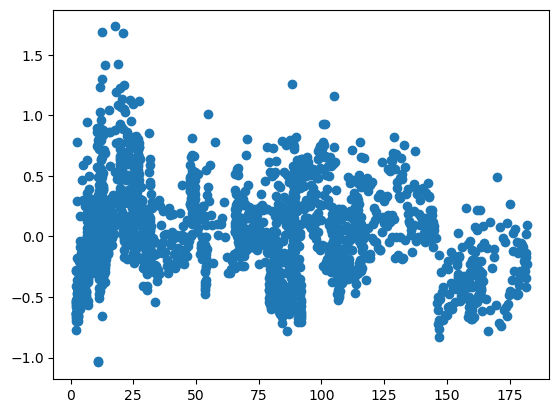

In [32]:
# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = bars_cls_linear['Close_50'].values, y = log_odds);
plt.show()

##### Assumption 4: Multicollinearity and Independence

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
bars_cls_linear.iloc[:, :6]

,Open_50,High_50,Low_50,Close_50,Volume,Signal
Date,,,,,,
2016-03-15,2.1646,2.240600,2.085600,2.157800,0.221095,0
2016-03-16,2.1592,2.237000,2.082800,2.155000,0.161584,1
2016-03-17,2.1592,2.237200,2.084000,2.156000,0.264590,0
2016-03-18,2.1620,2.241600,2.090000,2.164500,0.266032,1
2016-03-21,2.1714,2.250000,2.099800,2.175000,0.167489,0
...,...,...,...,...,...,...
2024-09-25,147.0381,149.725046,143.367744,146.194000,0.293559,1
2024-09-26,146.9832,149.702646,143.461344,146.355200,0.307031,0
2024-09-27,147.0646,149.809018,143.672144,146.526800,0.255513,0


In [35]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(bars_cls_linear.iloc[:, :6])

,variables,VIF
0,Open_50,549498.823176
1,High_50,606364.086267
2,Low_50,500515.141701
3,Close_50,671537.535268
4,Volume,3.700386
5,Signal,2.077191


##### Add input vars

RSI, MACD, Bollinger Bands

In [70]:
def rsi(df, window):
    delta = df.diff().dropna()
    part1_gain = (delta.where(delta > 0, 0)).shift(1).rolling(window=window-1).mean()
    part2_gain = (delta.where(delta > 0, 0))
    gain = (part1_gain * (window-1) + part2_gain)/window
    
    part1_loss = (-delta.where(delta < 0, 0)).shift(1).rolling(window=window-1).mean()
    part2_loss = (-delta.where(delta < 0, 0))
    loss = (part1_loss * (window-1) + part2_loss)/window
    rs = gain / loss
    # df['RSI'] = 100 - (100 / (1 + rs))
    return 100 - (100 / (1 + rs))


def rsi_cat(df, window):
    df1 = rsi(df, window).dropna()
    return df1.apply(lambda x: 1 if x > 70 else (-1 if x < 30 else 0))

In [95]:
def add_factors(bars):
    bars['rsi'] = rsi(bars['Close'], 14)
    bars['rsi_cat'] = rsi_cat(bars['Close'], 14)
    
    bars['return'] = bars['Close'].pct_change()
    bars['log_return'] = np.log(bars['Close'].pct_change()+1)
    
    bars['volume_change'] = bars['Volume'].pct_change()
    bars['volume_sqrt'] = bars['Volume'].apply(lambda x: np.sqrt(x))
    
    bars['MA5'] = bars['Close'].rolling(window=5).mean()
    bars['MA10'] = bars['Close'].rolling(window=10).mean()
    
    bars['EMA12'] = bars['Close'].ewm(span=12, adjust=False).mean()
    bars['EMA26'] = bars['Close'].ewm(span=26, adjust=False).mean()
    bars['MACD'] = bars['EMA26'] - bars['EMA12']
    bars['Signal_Line'] = bars['MACD'].ewm(span=9, adjust=False).mean()
    
    cols = bars.columns.tolist()
    cols.remove('Signal')
    cols.append('Signal')
    bars = bars[cols]
    
    
    return bars

In [96]:
bars_cls = add_factors(bars_cls).dropna()

1. RSI

In [94]:
delta = 0.015
bars_cls = bars.copy()[['Close', 'Volume']]
bars_cls['Signal'] = [int(row['High'] >= (1 + delta) * row['Open']) for idx, row in bars.iterrows()]

In [97]:
bars_cls

,Close,Volume,rsi,rsi_cat,return,log_return,volume_change,volume_sqrt,MA5,MA10,EMA12,EMA26,MACD,Signal_Line,Signal
Date,,,,,,,,,,,,,,,
2016-01-25,2.12,13378300.0,33.160622,0.0,0.049505,0.048319,-0.204482,3657.635848,1.996,2.120,2.170266,2.362798,0.192532,0.165283,1
2016-01-26,2.07,11774462.0,32.653061,0.0,-0.023585,-0.023867,-0.119884,3431.393594,2.020,2.093,2.154841,2.341109,0.186269,0.169480,0
2016-01-27,2.13,11195852.0,39.436620,0.0,0.028986,0.028573,-0.049141,3346.020323,2.086,2.067,2.151019,2.325472,0.174452,0.170475,1
2016-01-28,2.08,7366820.0,43.887147,0.0,-0.023474,-0.023754,-0.342005,2714.188645,2.084,2.050,2.140093,2.307289,0.167195,0.169819,0
2016-01-29,2.20,13464666.0,51.898734,0.0,0.057692,0.056089,0.827745,3669.423115,2.120,2.049,2.149310,2.299341,0.150032,0.165861,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-25,162.02,35233264.0,76.639924,1.0,0.023370,0.023101,0.279758,5935.761451,157.956,154.405,153.713157,150.563029,-3.150128,-1.460783,1
2024-09-26,167.49,38044919.0,88.751169,1.0,0.033761,0.033204,0.079801,6168.056339,160.106,156.077,155.832672,151.816879,-4.015793,-1.971785,0
2024-09-27,164.35,27876037.0,81.116390,1.0,-0.018747,-0.018925,-0.267286,5279.776226,161.786,157.281,157.143030,152.745258,-4.397772,-2.456983,0


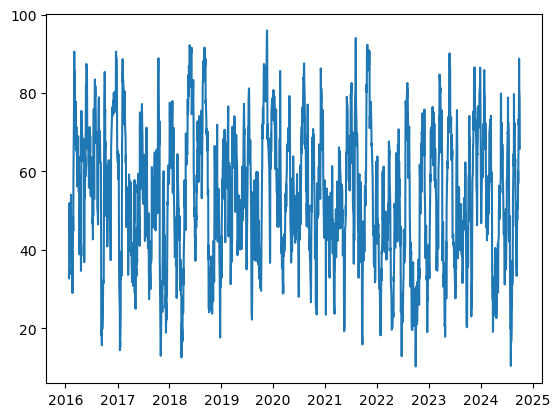

In [69]:
def rsi(df, window=14):
    delta = df.diff().dropna()
    part1_gain = (delta.where(delta > 0, 0)).shift(1).rolling(window=window-1).mean()
    part2_gain = (delta.where(delta > 0, 0))
    gain = (part1_gain * (window-1) + part2_gain)/window
    
    part1_loss = (-delta.where(delta < 0, 0)).shift(1).rolling(window=window-1).mean()
    part2_loss = (-delta.where(delta < 0, 0))
    loss = (part1_loss * (window-1) + part2_loss)/window
    rs = gain / loss
    # df['RSI'] = 100 - (100 / (1 + rs))
    return 100 - (100 / (1 + rs))


def rsi_cat(df, window):
    df1 = rsi(df, window).dropna()
    return df1.apply(lambda x: 1 if x > 70 else (-1 if x < 30 else 0))
    
# rsi_cat(bars_cls['Close_50'], 14)
plt.plot(rsi(bars['Close']).dropna())

2. Returns

In [ ]:
bars['Close'].pct_change()

3. Log Returns (log(1+x))

In [ ]:
np.log(bars['Close'].pct_change()+1)

4. Volume Change

In [ ]:
bars['Volume'].pct_change()

5. Sqrt Volume

In [ ]:
bars['Volume'].apply(lambda x: np.sqrt(x))

6. MA5, MA10

In [ ]:
bars['Close'].rolling(window=5).mean()
bars['Close'].rolling(window=10).mean()

7. MACD

In [ ]:
exp1 = bars['Close'].ewm(span=12, adjust=False).mean()
exp2 = bars['Close'].ewm(span=26, adjust=False).mean()
exp1 - exp2

##### Training & Testing

In [74]:
# X = bars_cls.drop(columns = ['Signal'])
# y = bars_cls["Signal"]

# # train_test_split 
# dev_test_split = int(0.8*X.shape[0])
# X_dev_df, X_test_df, y_dev_df, y_test_df= X.iloc[:dev_test_split], X.iloc[dev_test_split:], y.iloc[:dev_test_split], y.iloc[dev_test_split:]


# train_val_split = int(0.75*X_dev_df.shape[0])
# X_train_df, X_val_df, y_train_df, y_val_df = X_dev_df.iloc[:train_val_split], X_dev_df.iloc[train_val_split:], y_dev_df.iloc[:train_val_split], y_dev_df.iloc[train_val_split:]                      

In [75]:
# period = 3

# full_data = pd.DataFrame()

# full_data.index = bars_cls.index

# for i in range(1, period + 1):
#     for feature in ['Open','High','Low','Close','Volume']: # ['Close','Volume']:
#         full_data[f'{feature}_-{i}'] = bars_cls[feature].shift(i)


        
# full_data['Signal_next'] = bars_cls['Signal'].shift(-1)

# full_data.dropna(inplace=True)
# full_data.head()

In [ ]:
# X = full_data.drop(columns = ['Signal_next'])
# y = full_data["Signal_next"]

# # train_test_split 
# dev_test_split = int(0.8*X.shape[0])
# X_dev_df, X_test_df, y_dev_df, y_test_df= X.iloc[:dev_test_split], X.iloc[dev_test_split:], y.iloc[:dev_test_split], y.iloc[dev_test_split:]


# train_val_split = int(0.75*X_dev_df.shape[0])
# X_train_df, X_val_df, y_train_df, y_val_df = X_dev_df.iloc[:train_val_split], X_dev_df.iloc[train_val_split:], y_dev_df.iloc[:train_val_split], y_dev_df.iloc[train_val_split:]                      

In [76]:
# ss = MinMaxScaler()
# X_train_scaled = ss.fit_transform(X_train_df)
# X_val_scaled = ss.transform(X_val_df)
# X_test_scaled = ss.transform(X_test_df)

In [78]:
len(X_train_scaled)

1303

In [99]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_curve, auc

In [98]:
X = bars_cls.drop(columns = ['Signal'])
y = bars_cls["Signal"]

In [130]:
# train_test_split 
dev_test_split = int(0.8*X.shape[0])
X_dev_df, X_test_df, y_dev_df, y_test_df= X.iloc[:dev_test_split].to_numpy(), X.iloc[dev_test_split:].to_numpy(), y.iloc[:dev_test_split].to_numpy(), y.iloc[dev_test_split:].to_numpy()

# TimeSeriesSplit cross-validation on the train set
tscv = TimeSeriesSplit(n_splits=5)

ss = MinMaxScaler()

# train_val_split = int(0.75*X_dev_df.shape[0])
# X_train_df, X_val_df, y_train_df, y_val_df = X_dev_df.iloc[:train_val_split], X_dev_df.iloc[train_val_split:], y_dev_df.iloc[:train_val_split], y_dev_df.iloc[train_val_split:]   
val_time_series_split_score = []
for train_idx, val_idx in tscv.split(X_dev_df):
    
    X_train, X_val, y_train, y_val = X_dev_df[train_idx], X_dev_df[val_idx], y_dev_df[train_idx], y_dev_df[val_idx]
    X_train_scaled = ss.fit_transform(X_train)
    X_val_scaled = ss.transform(X_val)

    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_scaled, y_train)
    pred_prob = clf.predict_proba(X_val_scaled)
    # Assuming pred_prob contains the predicted probabilities for the positive class
    y_score = pred_prob[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_score)
    
    # Calculate the AUC
    val_time_series_split_score.append(auc(fpr, tpr))

print(f"Average validation auroc score is {np.mean(val_time_series_split_score)}")

Average validation auroc score is 0.7895944698359043
Test auroc socre is 0.7993827160493827


In [151]:
# pred_prob

In [132]:
import pickle

In [133]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

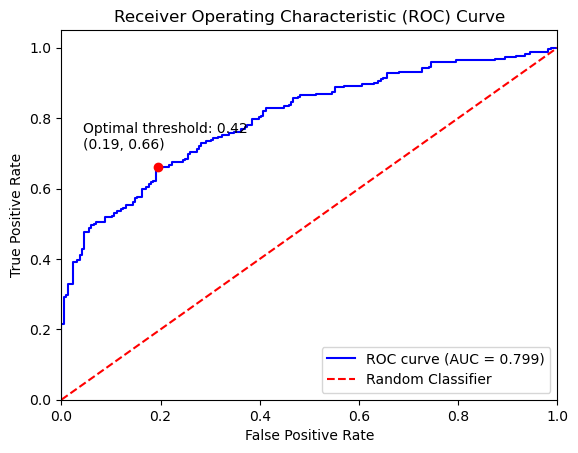

In [131]:
from sklearn.metrics import roc_curve, auc

X_dev_scaled = ss.fit_transform(X_dev_df)
X_test_scaled = ss.transform(X_test_df)

# clf.fit(X_dev_scaled, y_dev_df)
y_score = clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_df, y_score)
# print(f"Test auroc socre is {auc(fpr, tpr)}")

# Calculate the AUC
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

# Plot the ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
ax.plot(optimal_point[0], optimal_point[1], 'ro', markersize=6)
ax.text(optimal_point[0]-0.15, optimal_point[1]+0.05, f'Optimal threshold: {optimal_threshold:.2f}\n({optimal_point[0]:.2f}, {optimal_point[1]:.2f})')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

pred_prob = clf.predict_proba(X_test_scaled)

# Assuming pred_prob contains the predicted probabilities for the positive class
y_score = pred_prob[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_df, y_score)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_point = (fpr[optimal_idx], tpr[optimal_idx])

# Plot the ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
ax.plot(optimal_point[0], optimal_point[1], 'ro', markersize=6)
ax.text(optimal_point[0]-0.15, optimal_point[1]+0.05, f'Optimal threshold: {optimal_threshold:.2f}\n({optimal_point[0]:.2f}, {optimal_point[1]:.2f})')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.show()

In [ ]:
signals = []
for i in range(len(pred_prob)):
    if pred_prob[i][1] > 0.38:
        signals.append(1)
    else:
        signals.append(0)
signals.head()

In [ ]:
X_test_df

In [147]:
signals = pd.DataFrame({'signals': signals}, index=X_test_df.index)

In [ ]:
# signals.shift(1) 
signals.shift(1)['signals'] * bars_cls['Close'].pct_change()[signals.index]

In [ ]:
Cumulative_Returns = (1 + signals.shift(1)['signals'] * bars_cls['Close'].pct_change()[signals.index]).cumprod()
Cumulative_Returns

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(X_test_df.index, Cumulative_Returns)
plt.title('AMD Investment Return Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

In [ ]:
res = []
for i in np.linspace(0.4, 0.7, num=100):
    pred = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > i else 0, axis=1)
#     conf_matrix = confusion_matrix(pred, y_train_df)

#     TP = conf_matrix[1, 1]
#     TN = conf_matrix[0, 0]
#     FP = conf_matrix[0, 1]
#     FN = conf_matrix[1, 0]
    
#     print((TP + TN) / sum(map(sum, conf_matrix)))
#     print(accuracy_score(y_train_df, pred))
    res.append(accuracy_score(y_test_df, pred))

fig = plt.figure()
ax = plt.axes()
ax.plot(np.linspace(0.4, 0.7, num=100), res)

In [100]:
threshold = np.linspace(0.4, 0.7, num=100)[res.index(max(res))]

In [ ]:
pred = pd.DataFrame(pred_prob).apply(lambda x: 1 if x[1] > 0.51 else 0, axis=1)
pred

In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [92]:
conf_matrix = confusion_matrix(pred, y_train_df)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

In [ ]:
# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division
print((TP / (TP + FP))) # precision
print((TP / (TP + FN))) # recall
print(accuracy_score(y_train_df, pred))

In [ ]:
### Code here
lgr = LogisticRegression(alpha=0, t=100, eta=1e-3)
loss_train = lgr.train(X_train_scaled, np.array(y_train_df.tolist()))

loss_train = np.squeeze(loss_train)

fig, ax = plt.subplots()
ax.plot(range(100), loss_train)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss over Epochs')

#### Linear Regression

In [ ]:
### Code here
lr = LinearRegression()
lr.train(X_train_scaled, y_train_df)

# predictions
y_pred_train = lr.predict(X_train_scaled)
y_pred_val = lr.predict(X_val_scaled)
y_pred_test = lr.predict(X_test_scaled)

# Export R^2
r2_train = r2_score(y_pred_train, y_train_df)
r2_val = r2_score(y_pred_val, y_val_df)
r2_test = r2_score(y_pred_test, y_test_df)
print(f"R^2 score on training set: {r2_train}")
print(f"R^2 score on training set: {r2_val}")
print(f"R^2 score on training set: {r2_test}")

# Get report
get_report(y_pred_train, y_train_df)
get_report(y_pred_val, y_val_df)
get_report(y_pred_test, y_test_df)

# Portfolio

In [134]:
class MarketOnClosePortfolio(Portfolio):
    def __init__(self, symbol, bars, signals, initial_capital=100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()

    def generate_positions(self):
        positions = pd.DataFrame(index=self.bars.index).fillna(0.0)
        positions[self.symbol] = 100 * self.signals["signal"]
        return positions.cumsum()

    def backtest_portfolio(self):
        # portfolio = pd.DataFrame({'pos_value': self.positions[self.symbol] * self.bars['Close']})

        # pos_diff = self.positions.diff()

        # portfolio['holdings'] = self.positions[self.symbol] * self.bars['Close']
        # portfolio['cash'] = self.initial_capital - (pos_diff[self.symbol] * self.bars['Close']).cumsum()

        # portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        # portfolio['returns'] = portfolio['total'].pct_change()

        portfolio = pd.DataFrame(index=self.bars.index)
        portfolio["holdings"] = self.positions[self.symbol] * self.bars["Close"]
        pos_diff = self.positions.diff()
        portfolio["cash"] = (
            self.initial_capital - (pos_diff[self.symbol] * self.bars["Close"]).cumsum()
        )
        portfolio["total"] = portfolio["cash"] + portfolio["holdings"]
        portfolio["returns"] = portfolio["total"].pct_change()

        return portfolio

In [135]:
class MarketOnOpenPortfolio(Portfolio):
    """Inherits Portfolio to create a system that purchases 100 units of
    a particular symbol upon a long/short signal, assuming the market
    open price of a bar.

    In addition, there are zero transaction costs and cash can be immediately
    borrowed for shorting (no margin posting or interest requirements).

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, 0, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, risk_ratio=0.05, stop_loss_percent=0.1, initial_capital=100000.0):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        # self.cash = self.initial_capital
        self.risk_ratio = risk_ratio
        self.stop_loss_percent = stop_loss_percent
        self.positions = self.generate_positions()
    
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index, columns=[self.symbol])
        positions[self.symbol] = positions[self.symbol].mask(pd.isna(positions[self.symbol]), 0)
        equity = [self.initial_capital] # length n
        
        for i in range(1, len(self.signals)):
            signal = self.signals['signal'].iloc[i]
            open_price = self.bars["Open"].iloc[i]
            prev_open_price = self.bars["Open"].iloc[i-1]

#             historical = [abs(j - self.initial_capital) for j in equity[:i]]
#             if max(historical) != 0:
#                 trade_risk = max(historical)
#             else:
#                 trade_risk = open_price

#             num_of_contract = int(equity[i-1] * self.risk_ratio / trade_risk)
            num_of_contract = int(equity[i-1] * self.risk_ratio / (open_price * self.stop_loss_percent))
            
            

            if signal == 1:
                positions.iloc[i] = num_of_contract
            elif signal == -1:
                positions.iloc[i] = 0
            else:
                positions.iloc[i] = positions.iloc[i-1]

            pnl = float(positions.iloc[i-1].values) * (open_price - prev_open_price)
            equity.append(equity[i-1] + pnl)

        return positions
    
    
    def backtest_portfolio(self):
        """Constructs a portfolio from the positions DataFrame by
        assuming the ability to trade at the precise market open price
        of each bar (an unrealistic assumption!).

        Calculates the total of cash and the holdings (market price of
        each position per bar), in order to generate an equity curve
        ('total') and a set of bar-based returns ('returns').

        Returns the portfolio object to be used elsewhere."""
    
        portfolio = pd.DataFrame(index=self.bars.index)
        portfolio["holdings"] = self.positions[self.symbol] * self.bars["Open"]
        pos_diff = self.positions.diff()
        portfolio["cash"] = (
            self.initial_capital - (pos_diff[self.symbol] * self.bars["Open"]).cumsum()
        )
        portfolio["equity"] = portfolio["cash"] + portfolio["holdings"]
        portfolio["returns"] = portfolio["equity"].pct_change()
        print(self.risk_ratio)

        return portfolio

In [136]:
# initial_capital = 100000
# symbol = 'AMD'
# positions = pd.DataFrame(index=signals.index, columns=[symbol])
# positions[symbol] = positions[symbol].mask(pd.isna(positions[symbol]), 0)
# equity = [initial_capital] # length n
# risk_ratio = 0.05

# for i in range(1, len(signals)):
#     signal = signals['signal'].iloc[i]
#     open_price = bars["Open"].iloc[i]
#     prev_open_price = bars["Open"].iloc[i-1]

#     historical = [abs(i - initial_capital) for i in equity[:i]]
#     if max(historical) != 0:
#         trade_risk = max(historical)
#     else:
#         trade_risk = open_price
    
#     num_of_contract = int(equity[i-1] * risk_ratio / trade_risk)

#     if signal != 0:
#         positions.iloc[i] = num_of_contract

#     else:
#         positions.iloc[i] = positions.iloc[i-1]

#     pnl = positions.iloc[i-1] * (open_price - prev_open_price)
#     equity.append(equity[i-1] + pnl)

# return positions

In [137]:
# initial_capital = 100000
# symbol = 'AMD'
# positions = pd.DataFrame(index=signals.index, columns=[symbol])
# positions[symbol] = positions[symbol].mask(pd.isna(positions[symbol]), 0)
# equity = [initial_capital] # length n
# risk_ratio = 0.05

# Performance

In [138]:
def create_sharpe_ratio(returns, risk_free_rate=0, periods=252):
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).

    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns) - risk_free_rate) / np.std(returns)


def create_drawdowns(equity_curve):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.

    Parameters:
    pnl - A pandas Series representing period percentage returns.

    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """
    
    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx, dtype=float)
    duration = pd.Series(index = eq_idx, dtype=float)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - equity_curve[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max(), duration.max()

# Execution

## Random Strategy Execution

In [139]:
if __name__ == "__main__":
    # Obtain daily bars of SPY (ETF that generally
    # follows the S&P500) from Quandl (requires 'pip install Quandl'
    # on the command line)

    # Fetch SPY data
    symbol = "SPY"
    bars = yf.download(symbol, period="2y")  # start='2024-05-01'
    bars.index = bars.index.date

    # Create a set of random forecasting signals for SPY
    rfs = RandomForecastingStrategy(symbol, bars)
    signals = rfs.generate_signals()

    # Create a portfolio of SPY
    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()

[*********************100%***********************]  1 of 1 completed

0.05



/var/folders/24/_vwy2y0n10scfhkf8kb16hmm0000gn/T/ipykernel_38418/1428518710.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals["signal"][0:5] = 0.0
/var/folders/24/_vwy2y0n10scfhkf8kb16hmm0000gn/T/ipykernel_38418/966422173.py:53: 

## Sentiment Analysis Execution

In [ ]:
if __name__ == "__main__":
    symbol = "AMD"
    bars = yf.download(tickers=symbol, period="1mo")
    threshold = 0.2
    news_api_key = userdata.get("news_api_key")

    senti_analysis = SentimentAnalysisStrategy(symbol, bars, threshold, news_api_key)
    signals = senti_analysis.generate_signals()

    portfolio = MarketOnClosePortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()

    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"], label="Close")
    ax[0].scatter(
        bars["Close"][signals["signal"] == 1.0].index,
        bars["Close"][signals["signal"] == 1.0].values,
        100,
        c="green",
        marker="^",
        label="Buy",
    )
    ax[0].scatter(
        bars["Close"][signals["signal"] == -1.0].index,
        bars["Close"][signals["signal"] == -1.0].values,
        100,
        c="red",
        marker="v",
        label="Sell",
    )

    ax[0].legend()
    ax[0].set_title(f"{symbol} Close price and Sentiment Analysis signals")
    ax[0].set_xlabel("Date")

    ax[1].plot(returns["total"], label="Portfolio value")
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["total"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
        label="Buy",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["total"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
        label="Sell",
    )

    ax[1].legend()
    ax[1].set_title(f"Portfolio value corresponding Sentiment Analysis")
    ax[1].set_xlabel("Date")

## Moving Average Crossovers Strategy Execution

In [ ]:
!pip install backtrader

In [32]:
from datetime import datetime
import backtrader as bt

In [ ]:
bars

In [ ]:
bars.values

In [ ]:
bars0 = pd.DataFrame(index=[pd.Timestamp(i) for i in bars.index])
bars0[bars.columns.tolist()] = bars.values
bars0

In [ ]:
%matplotlib inline

class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=10), bt.ind.SMA(period=30)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

bars0 = pd.DataFrame(index=[pd.Timestamp(i) for i in bars.index])
bars0[bars.columns.tolist()] = bars.values
data0 = bt.feeds.PandasData(dataname=bars0)
bars
cerebro.adddata(data0)

cerebro.run()
cerebro.plot()

In [ ]:
bars.index[0].to_pydatetime()

In [24]:
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical import StockHistoricalDataClient # Create stock historical data client

In [ ]:
bars["Close"]

In [ ]:
signals

In [56]:
def backtesting_plot(signals, returns):
    """
    signals: dataframe with column 0/1
    returns: dataframe with [[holdings, cash, equity, returns]]
    """
    
    # backtesting results
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"], label="Close")
    ax[0].scatter(
        bars["Close"][signals["signal"] == 1.0].index,
        bars["Close"][signals["signal"] == 1.0],
        100,
        c="green",
        marker="^",
    ) # buy signals
    ax[0].scatter(
        bars["Close"][signals["signal"] == -1.0].index,
        bars["Close"][signals["signal"] == -1.0],
        100,
        c="red",
        marker="v",
    ) # sell signals
    
    
    if "short_mavg" in signals.columns:
        # Long/short moving average
        ax[0].plot(signals[["short_mavg", "long_mavg"]], label=["short_sma", "long_sma"])
        ax[0].set_title(
            f"{symbol} Close price and {short_window}d-SMA and {long_window}d-SMA for {int(len(signals)/252)} years"
        )
    else:
        ax[0].set_title(
            f"{symbol} Close price for {int(len(signals)/252)} years"
        )
    
    ax[0].set_xlabel("Date")
    ax[0].legend()
    
    # Equity curve
    ax[1].plot(returns["equity"])
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["equity"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["equity"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
    )

In [ ]:
if __name__ == "__main__":
    # symbol = "AMD"
    # symbol = 'NKE'
    symbol = 'NVDA'
    
    # Load data
    # bars = yf.download(tickers=symbol, period="10y")
    api_key = "PK6IRONYS5AQ646ZTDKX"
    api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
    start_date = "2014-01-01 00:00:00"
    client = StockHistoricalDataClient(api_key, api_secret)
    bars = DataLoader(client).fetch_historical_data(symbol, start_date)
    
    
    short_window, long_window = 50, 100

    mac = MovingAverageCrossStrategy(
        symbol, bars, short_window=short_window, long_window=long_window
    )
    signals = mac.generate_signals()

    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, risk_ratio=0.05, stop_loss_percent=0.1, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()
    

    backtesting_plot(signals, returns)

In [ ]:
2016-01-04 05:00:00+00:00

In [ ]:
signals["signal"][signals["signal"] == 1.0]

In [ ]:
signals[signals["signal"] == 1.0]

In [ ]:
np.mean(returns['returns'])

In [ ]:
create_sharpe_ratio(returns['returns'])

In [ ]:
create_drawdowns(returns['returns'])

In [ ]:
len(returns['returns'].dropna().tolist()) / 252

In [ ]:
# Step 1: Calculate the total return over the entire period
daily_returns = np.mean(returns['returns'].dropna().tolist())
# total_return = np.prod(1 + daily_returns) - 1
total_return = returns['equity'][-1] / returns['equity'][1]

# Step 2: Calculate the number of years
n_years = len(returns['returns'].dropna().tolist()) / 252  # Assuming 252 trading days in a year

# Step 3: Calculate the annualized return
annualized_return = (1 + total_return) ** (1 / n_years) - 1

print(f"Annualized Return: {annualized_return*100:.2f}%")

## Logistic Regression execution

In [143]:
def add_factors2(bars):
    bars['rsi'] = rsi(bars['Close'], 14)
    bars['rsi_cat'] = rsi_cat(bars['Close'], 14)
    
    bars['return'] = bars['Close'].pct_change()
    bars['log_return'] = np.log(bars['Close'].pct_change()+1)
    
    bars['volume_change'] = bars['Volume'].pct_change()
    bars['volume_sqrt'] = bars['Volume'].apply(lambda x: np.sqrt(x))
    
    bars['MA5'] = bars['Close'].rolling(window=5).mean()
    bars['MA10'] = bars['Close'].rolling(window=10).mean()
    
    bars['EMA12'] = bars['Close'].ewm(span=12, adjust=False).mean()
    bars['EMA26'] = bars['Close'].ewm(span=26, adjust=False).mean()
    bars['MACD'] = bars['EMA26'] - bars['EMA12']
    bars['Signal_Line'] = bars['MACD'].ewm(span=9, adjust=False).mean()
    
    return bars

In [161]:
signals.value_counts()

signal
1         1270
0          917
Name: count, dtype: int64

In [159]:
returns

,holdings,cash,equity,returns
Date,,,,
2016-01-27,39283.64,60716.36,100000.0,0.000000
2016-01-28,40599.36,60716.36,101315.72,0.013157
2016-01-29,42364.3,57635.7,100000.0,-0.012986
2016-02-01,43985.9,57635.7,101621.6,0.016216
2016-02-02,42769.7,57635.7,100405.4,-0.011968
...,...,...,...,...
2024-09-25,619893.5,517798.9014,1137692.4014,0.003603
2024-09-26,645500.52,525650.4864,1171151.0064,0.029409
2024-09-27,647142.72,525650.4864,1172793.2064,0.001402


/var/folders/24/_vwy2y0n10scfhkf8kb16hmm0000gn/T/ipykernel_38418/966422173.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pnl = float(positions.iloc[i-1].values) * (open_price - prev_open_price)
/var/folders/24/_vwy2y0n10scfhkf8kb16hmm0000gn/T/ipykernel_38418/966422173.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio["returns"] = portfolio["equity"].pct_change()


0.05


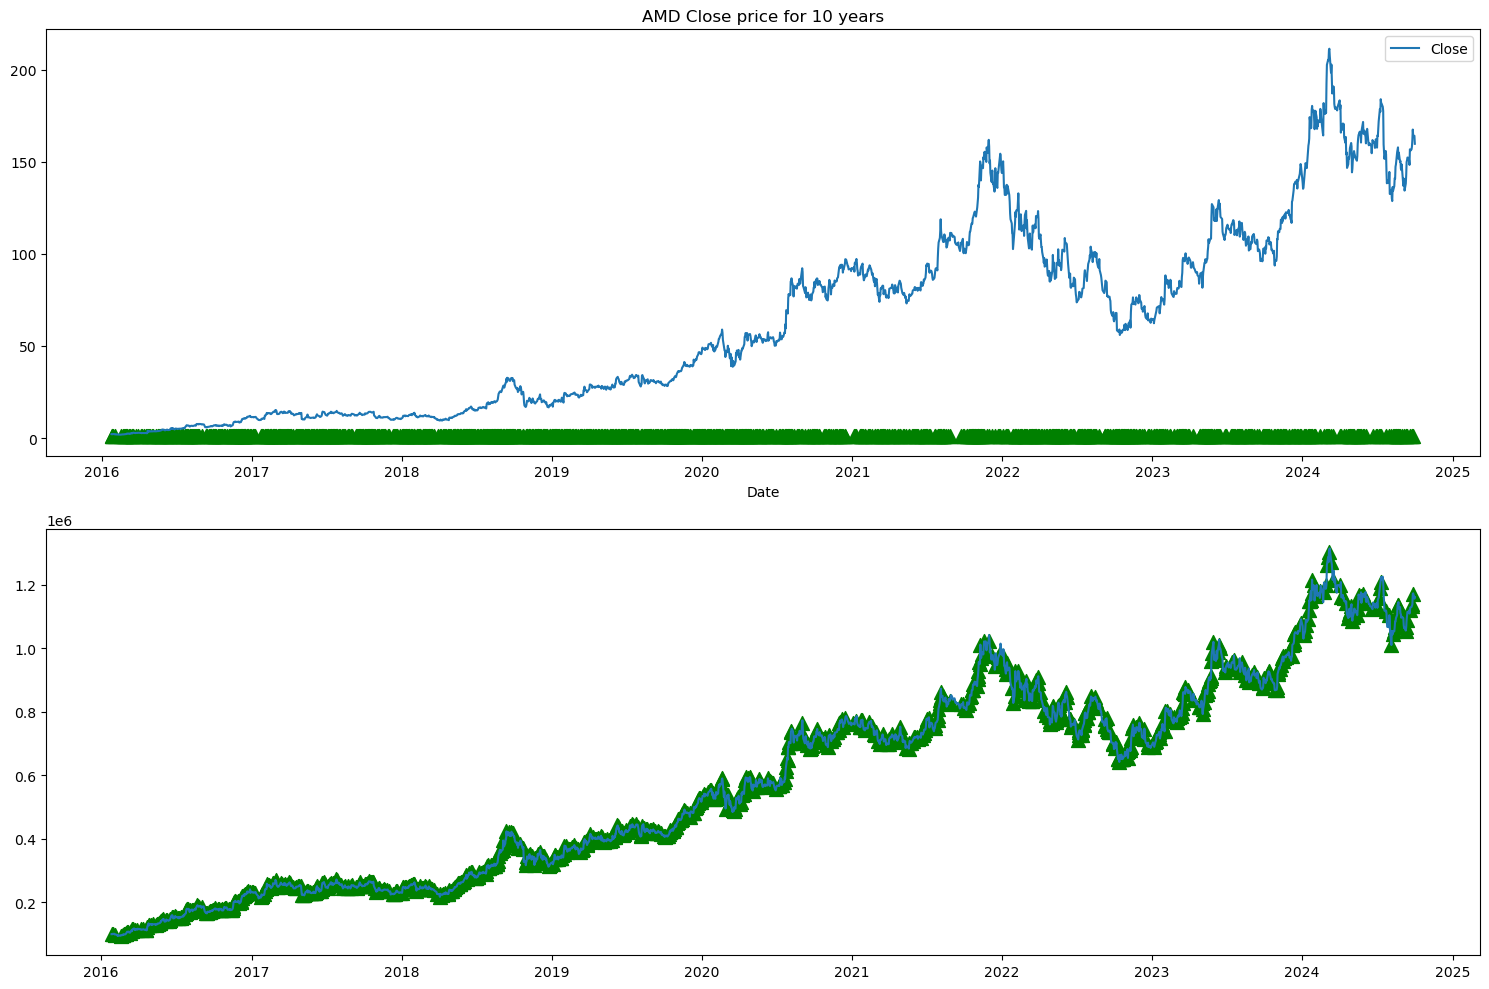

In [155]:
if __name__ == "__main__":
    symbol = "AMD"
    
    # Load data
    # bars = yf.download(tickers=symbol, period="10y")
#     api_key = "PK6IRONYS5AQ646ZTDKX"
#     api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
#     client = StockHistoricalDataClient(api_key, api_secret)
#     request_params = StockBarsRequest(
#                             symbol_or_symbols=[symbol],
#                             timeframe=TimeFrame.Day,
#                             start="2014-01-01 00:00:00"
#                      )
#     bars = client.get_stock_bars(request_params)
#     bars_df = bars.df

#     bars_df = (
#         bars_df[['open', 'high', 'low', 'close', 'volume']]
#         .reset_index().drop('symbol', axis=1)
#     )

#     bars = (
#         bars_df
#         .set_index(pd.to_datetime(bars_df['timestamp']))
#         .rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
#     )

#     bars.index = bars.index.strftime('%Y-%m-%d')
#     bars.index.name = 'Date'

    api_key = "PK6IRONYS5AQ646ZTDKX"
    api_secret = "HEYwi2T3MzAmYgednADOq0g6pEjuULcEz0Hbdqg8"
    client = StockHistoricalDataClient(api_key, api_secret)

    start_date = "2014-01-01 00:00:00"

    data_loader = DataLoader(client)
    bars = data_loader.fetch_historical_data(symbol, start_date=start_date)
    
    
    period = 14
    full_data = bars.copy()[['Close', 'Volume']]
    # feature_lst = ['Open', 'High', 'Low', 'Close', 'Volume']
    # full_data[feature_lst] = full_data[feature_lst].rolling(period).mean()
    # full_data.dropna(inplace=True)

    
    full_data = add_factors2(full_data)
    full_data.dropna(inplace=True)
#     full_data = pd.DataFrame()
#     full_data.index = bars.index

#     for i in range(1, period + 1):
#         for feature in ['Open','High','Low','Close','Volume']: # ['Close','Volume']:
#             full_data[f'{feature}_-{i}'] = bars[feature].shift(i)

#     full_data.dropna(inplace=True)
    
    clf_pred = pickle.load(open(filename, 'rb'))
    threshold = 0.42
    lgr = LogisticRegressionStrategy(threshold, symbol, full_data, clf_pred)
    signals = lgr.generate_signals()
    

    portfolio = MarketOnOpenPortfolio(symbol, bars, signals, initial_capital=100000.0)
    returns = portfolio.backtest_portfolio()[period:]
    
    
    # backtesting results
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)
    # fig.patch.set_facecolor('white')
    ax[0].plot(bars["Close"][period:], label="Close")
    ax[0].scatter(
        signals[signals["signal"] == 1.0].index,
        signals[signals["signal"] == 1.0],
        100,
        c="green",
        marker="^",
    )
    ax[0].scatter(
        signals[signals["signal"] == -1.0].index,
        signals[signals["signal"] == -1.0],
        100,
        c="red",
        marker="v",
    )
    ax[0].legend()
    ax[0].set_title(
        f"{symbol} Close price for 10 years"
    )
    ax[0].set_xlabel("Date")

    ax[1].plot(returns["equity"])
    ax[1].scatter(
        returns[signals["signal"] == 1.0].index,
        returns["equity"][signals["signal"] == 1.0],
        s=100,
        c="green",
        marker="^",
    )
    ax[1].scatter(
        returns[signals["signal"] == -1.0].index,
        returns["equity"][signals["signal"] == -1.0],
        s=100,
        c="red",
        marker="v",
    )

In [ ]:
portfolio.generate_positions()

In [156]:
# Step 1: Calculate the total return over the entire period
daily_returns = np.mean(returns['returns'].dropna().tolist())
# total_return = np.prod(1 + daily_returns) - 1
total_return = returns['equity'][-1] / returns['equity'][1]

# Step 2: Calculate the number of years
n_years = len(returns['returns'].dropna().tolist()) / 252  # Assuming 252 trading days in a year

# Step 3: Calculate the annualized return
annualized_return = (1 + total_return) ** (1 / n_years) - 1

print(f"Annualized Return: {annualized_return*100:.2f}%")

Annualized Return: 33.95%


/var/folders/24/_vwy2y0n10scfhkf8kb16hmm0000gn/T/ipykernel_38418/3677910553.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = returns['equity'][-1] / returns['equity'][1]


In [168]:
(np.mean(returns['returns'].dropna().tolist()) * 252 - 0.02) / (np.std(returns['returns'].dropna().tolist()) * np.sqrt(252))

1.0702422180024282

In [166]:
(np.mean(bars['Close'].tolist()) / np.std(bars['Close'].tolist())) * np.sqrt(252)

19.700986156014924